In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import binary_dilation, distance_transform_edt
from skimage.measure import label, regionprops
from skimage import measure
from skimage import exposure
from czifile import imread
import torch
from huggingface_hub import hf_hub_download
from cellpose import models 
model_cellpose = models.Cellpose(model_type='cyto')
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [58]:
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def count(mask): 
    """Count the number of unique labels in the mask."""
    return len(np.unique(label(mask))) - 1  # Exclude background label (0)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    return confocal_img

    return circular_mask, non_circular_mask
def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model_cellpose.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def find_swiss_cheese_inclusions(inclusion_image, red_channel_thresholded, verbose=False):

    """
    Identify and categorize inclusion objects based on their overlap with lipid droplets.
    - Labels individual inclusion objects in the binary inclusion image.
    - For each inclusion:
        - Checks whether it overlaps with the thresholded red channel (e.g., lipid droplets).
        - If it overlaps, adds it to the "swiss cheese" mask (inclusions with holes).
        - Otherwise, adds it to the "regular inclusion" mask (solid inclusions).
    - Returns two binary masks:
        - swiss_chess_inclusions: inclusions that intersect with the red channel
        - regular_inclusions: inclusions that do not intersect with the red channel
    """
    swiss_chess_inclusions = np.zeros_like(inclusion_image)
    regular_inclusions = np.zeros_like(inclusion_image)
    labeled_inclusions = label(inclusion_image)
    for i, inclusion in enumerate(regionprops(labeled_inclusions)):
        mask = labeled_inclusions == inclusion.label
        overlap = mask * red_channel_thresholded
        if np.sum(overlap) > 0:
            swiss_chess_inclusions += mask
        else:
            regular_inclusions += mask
    return swiss_chess_inclusions, regular_inclusions


def remove_overlapping_objects(mask1, mask2):

    # Label mask1 if it's not already labeled
    labeled_mask1 = label(mask1)
    result_mask = np.zeros_like(mask1, dtype=np.uint8)

    for region in regionprops(labeled_mask1):
        obj_mask = (labeled_mask1 == region.label)

        # Check if it overlaps with mask2
        if np.any(obj_mask & (mask2 > 0)):
            continue  # Skip overlapping object
        else:
            result_mask[obj_mask] = 1  # Keep the non-overlapping object

    return result_mask

def extract_touching_objects(mask1, mask2):
    """
    Return a mask containing whole objects in mask1
    that touch mask2.
    """
    touching_objects = np.zeros_like(mask1, dtype=np.uint8)

    labeled_mask = label(mask1)

    for region in regionprops(labeled_mask):
        region_mask = (labeled_mask == region.label)
        overlap = region_mask * mask2

        if np.sum(overlap) > 0:
            touching_objects += region_mask

    return touching_objects

def count_touching_objects(mask1, mask2):
    """
    Count how many objects in mask1 touch any part of mask2.

    Parameters:
        mask1 (ndarray): Binary or labeled mask (objects to test).
        mask2 (ndarray): Binary mask (objects to touch against).

    Returns:
        int: Number of objects in mask1 that touch mask2.
    """
    # Ensure binary input
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    labeled_mask1 = label(mask1)
    count = 0

    for region in regionprops(labeled_mask1):
        obj_mask = labeled_mask1 == region.label
        if np.any(obj_mask & mask2):
            count += 1

    return count

def circularity_index(mask):
    regions = measure.regionprops(label(mask))

    # Create empty masks to store the results
    clustered_lds = np.zeros_like(mask, dtype=bool)
    single_lds = np.zeros_like(mask, dtype=bool)

    # Iterate through regions and calculate circularity
    for region in regions:
        area = region.area
        perimeter = measure.perimeter(region.image)
        
        # Avoid division by zero
        if perimeter == 0 or area <= 10:
            continue
        
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        
        # Assign region to the appropriate mask based on circularity
        if circularity < 0.5:
            # Mask for clustered regions
            clustered_lds[region.coords[:, 0], region.coords[:, 1]] = 1
        else:
            # Mask for non-clustered regions
            single_lds[region.coords[:, 0], region.coords[:, 1]] = 1
    
    clustered_lds = clustered_lds.astype(bool)
    single_lds = single_lds.astype(bool)

    return clustered_lds, single_lds

In [60]:
@torch.no_grad()
def analysis(orange: np.ndarray, blue:np.ndarray, path:str) -> pd.DataFrame:

    data = []
    df_cell_summary = pd.DataFrame()

    data_lipid_distance = []
    df_lipid_distance = pd.DataFrame()

    print("Starting analysis...")



    #segement orange and blue channels to find desired objects
    orange = normalize_image(orange)
    contrast_adjusted_orange_normalized = (orange - orange.min()) / (orange.max() - orange.min())
    threshold_value_orange = np.mean(contrast_adjusted_orange_normalized) + (np.std(contrast_adjusted_orange_normalized) * 3) 
    orange_thresholded = contrast_adjusted_orange_normalized > threshold_value_orange
    orange_thresholded = remove_small_objects(orange_thresholded, min_size=10)

    contrast_adjusted_blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
    threshold_value_blue = np.mean(contrast_adjusted_blue_normalized) + (np.std(contrast_adjusted_blue_normalized) * 3) 
    blue_thresholded = contrast_adjusted_blue_normalized > threshold_value_blue
    blue_thresholded = remove_small_objects(blue_thresholded, min_size=10)

    #remove the orange and inclusion overlap


    display_two_images(blue, blue_thresholded, "Blue Channel", "Blue Thresholded", path)
    display_two_images(orange, orange_thresholded, "Orange Channel", "Orange Thresholded", path)

    clustered_lds, single_lds = circularity_index(orange_thresholded)

    display_two_images(single_lds, clustered_lds, "Single LDS", "Clustered LDs", path)
    dist_map = distance_transform_edt(~blue_thresholded)
    data.append({
        'Image Path': path,
        "MFI of LDS": np.mean(orange[orange_thresholded]),
        "MFI of mitochondria": np.mean(blue[blue_thresholded]),
        "Number of Single LDs": count(single_lds),
        "Number of Clustered LDs": count(clustered_lds),
        "Size of Single LDs": calculate_surface_area(label(single_lds)),
        "Size of Clustered LDs": calculate_surface_area(label(clustered_lds)),
    })
    lipid_droplet_num = 1
    for props in regionprops(label(orange_thresholded)):
        coords = np.array(props.coords)
        d_edge_px = float(dist_map[coords[:, 0], coords[:, 1]].min())

        data_lipid_distance.append({
            'Image Path': path,
            'lipid_droplet_num': lipid_droplet_num,
            'Distance to nearest mitochondria': d_edge_px
        })
        lipid_droplet_num += 1
    df_cell_summary = pd.DataFrame(data)
    df_lipid_distance = pd.DataFrame(data_lipid_distance)
    return df_cell_summary, df_lipid_distance

Starting analysis...


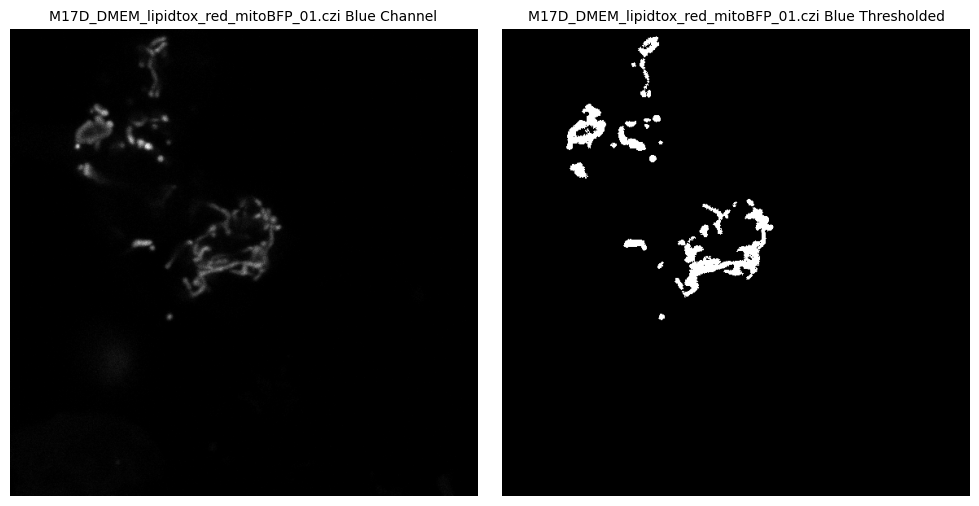

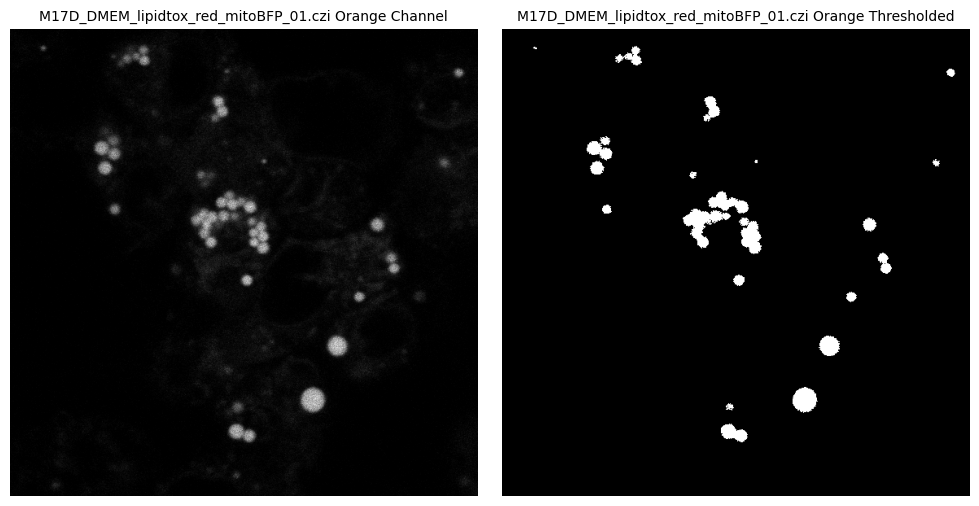

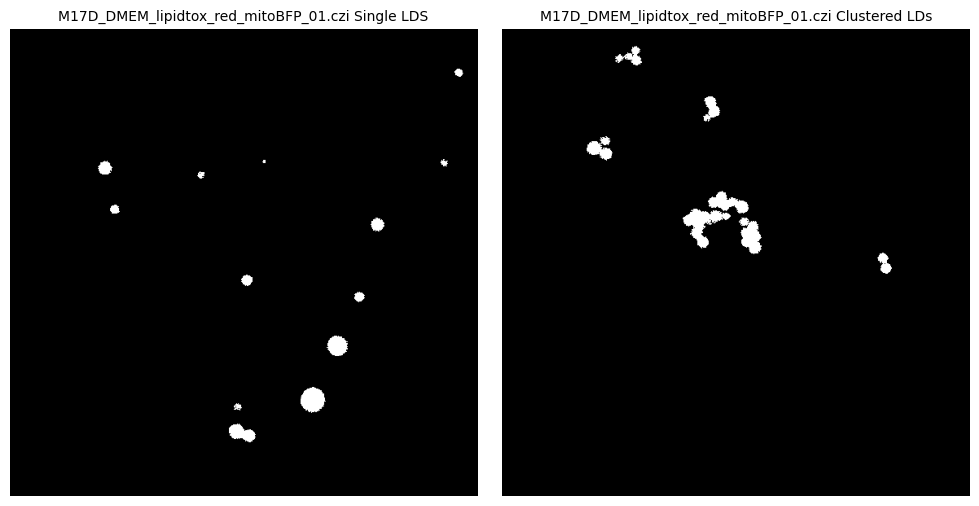

Starting analysis...


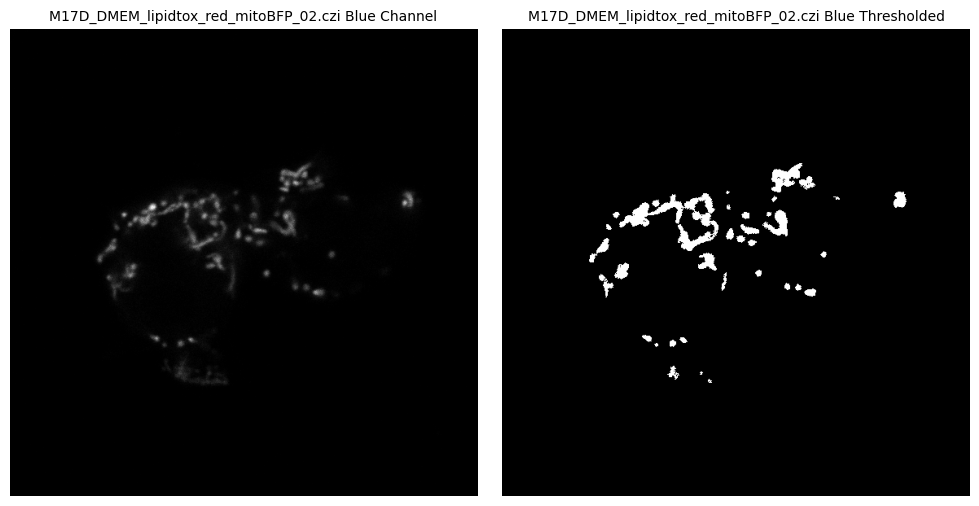

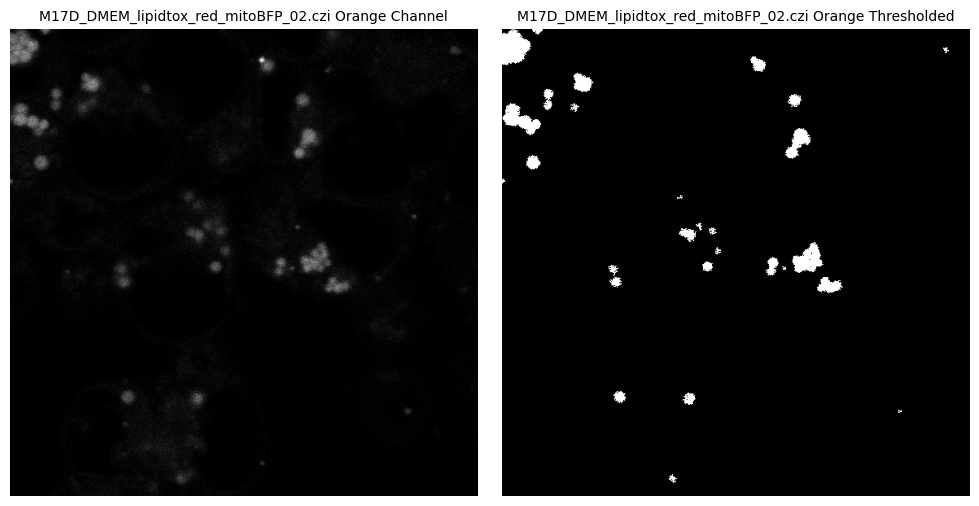

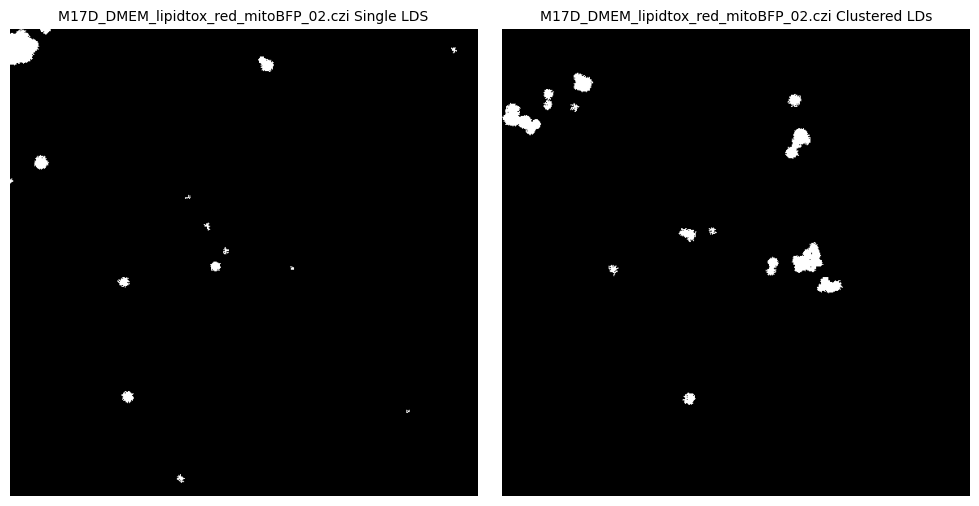

Starting analysis...


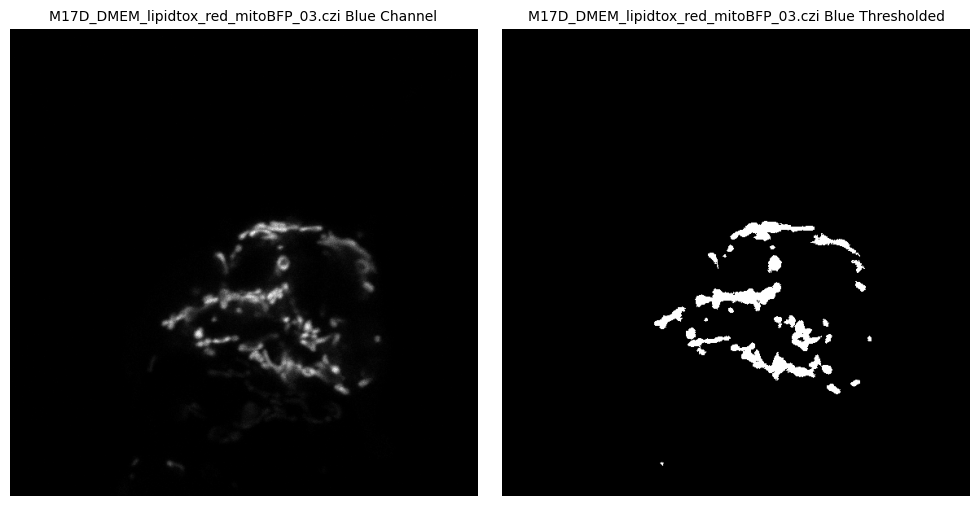

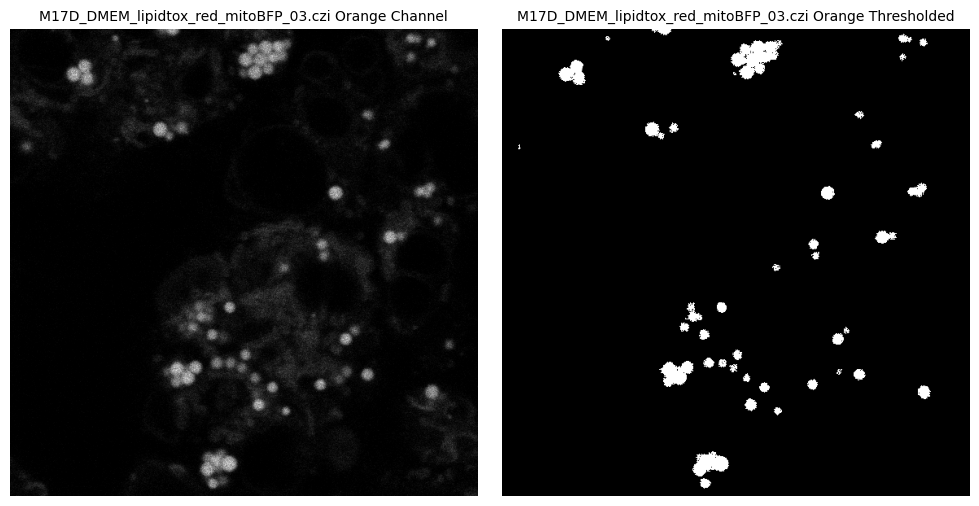

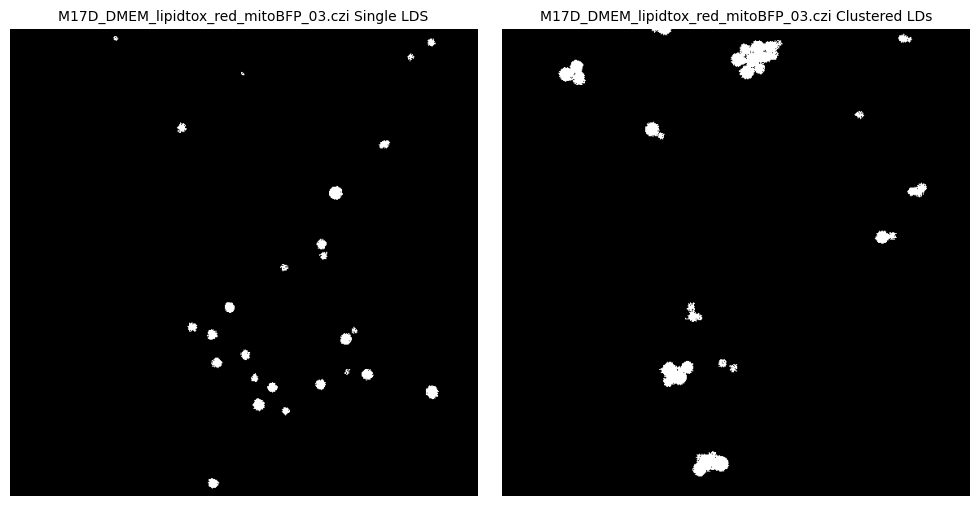

Starting analysis...


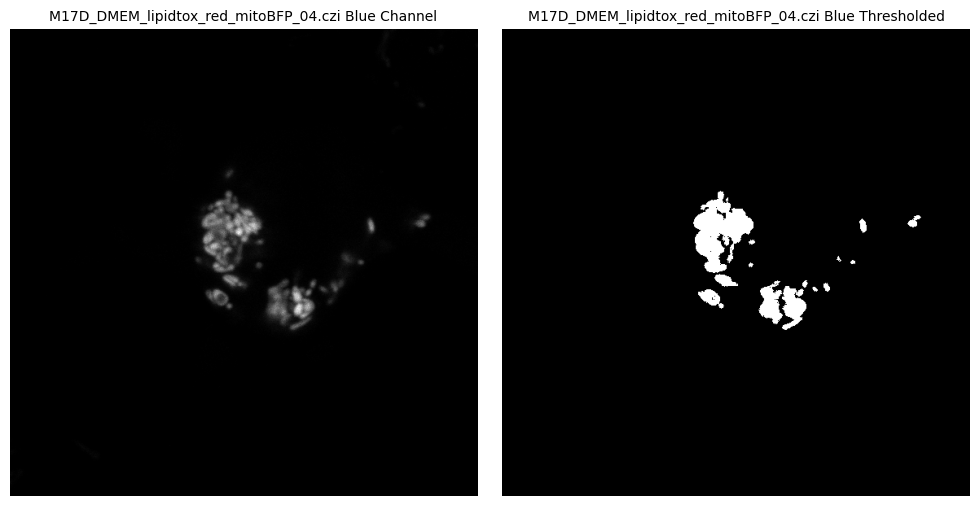

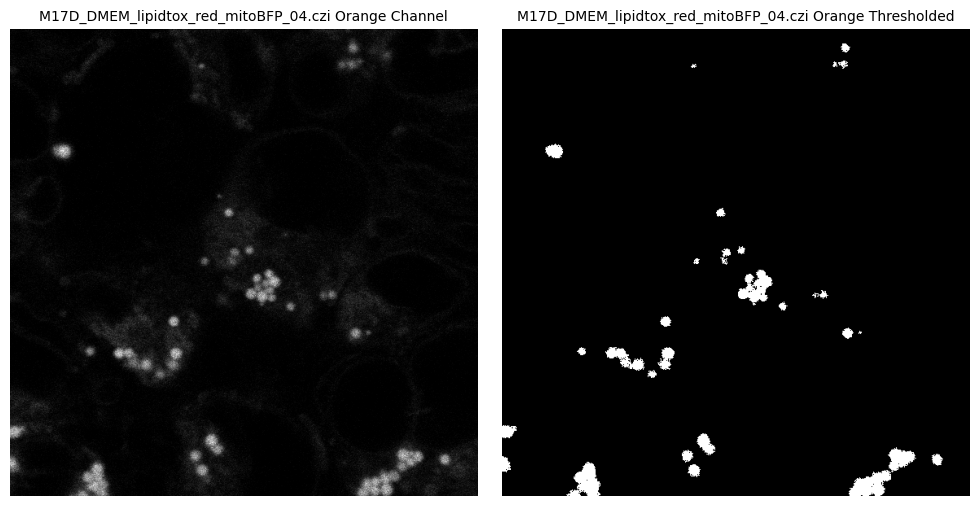

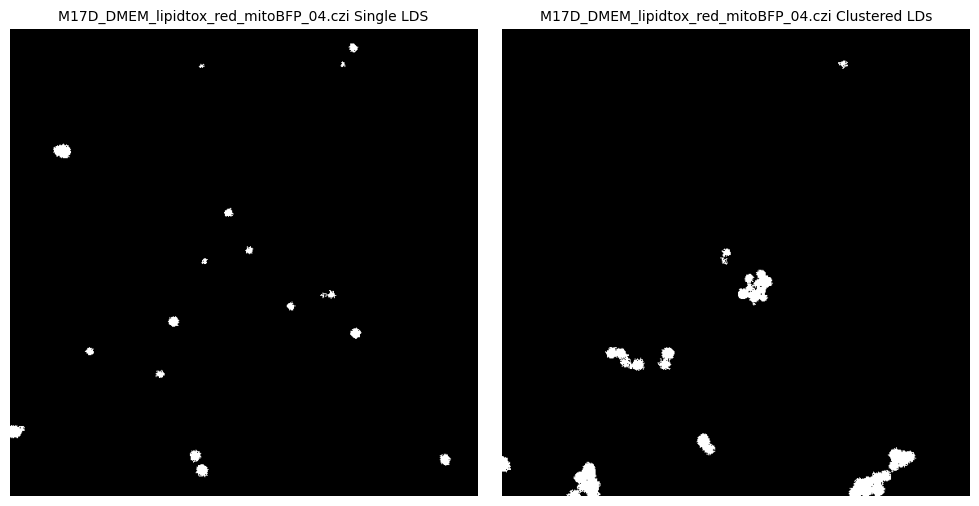

Starting analysis...


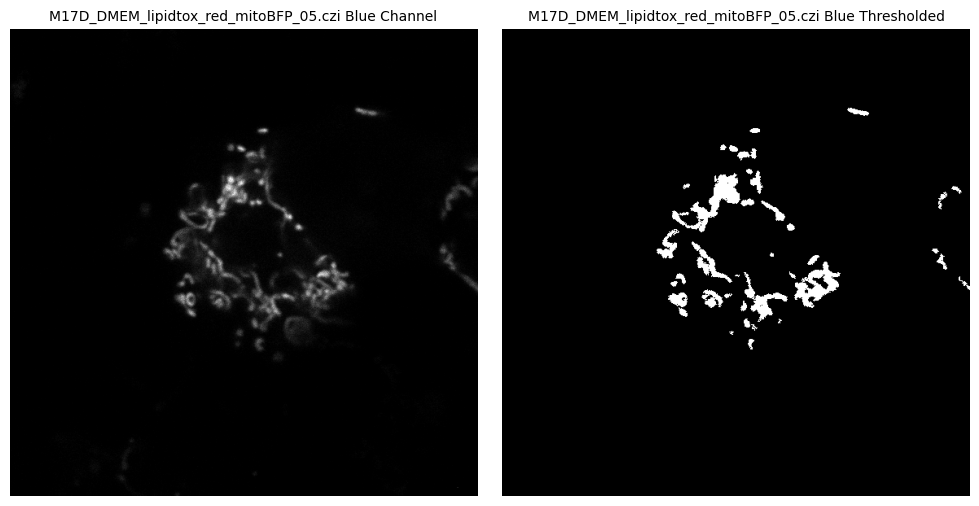

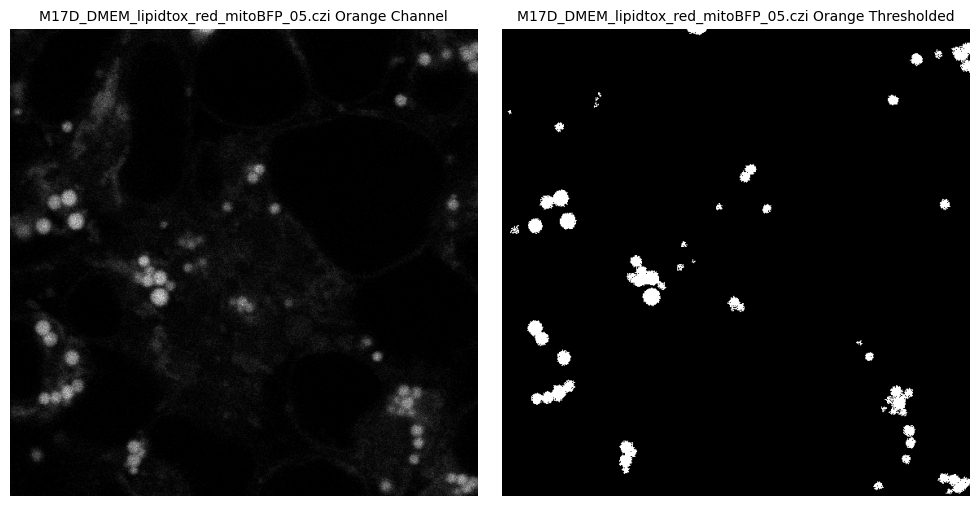

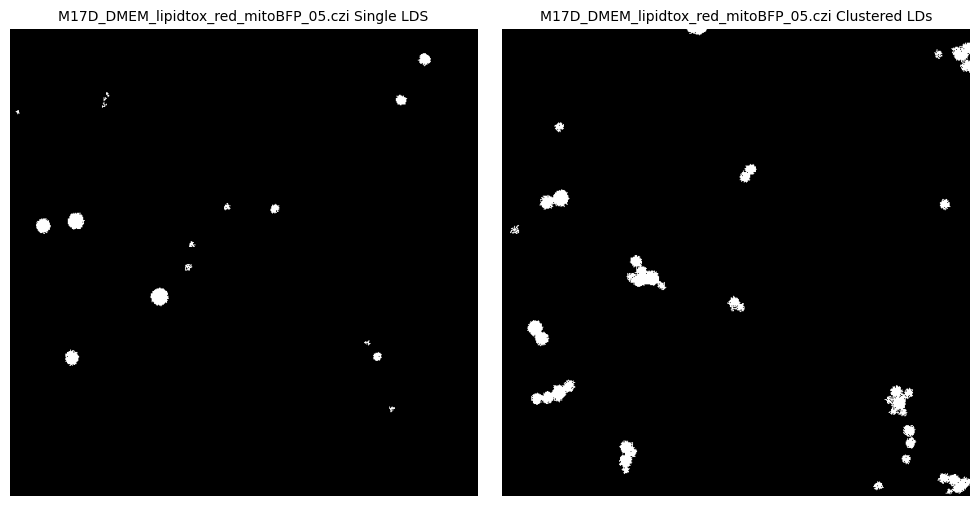

Starting analysis...


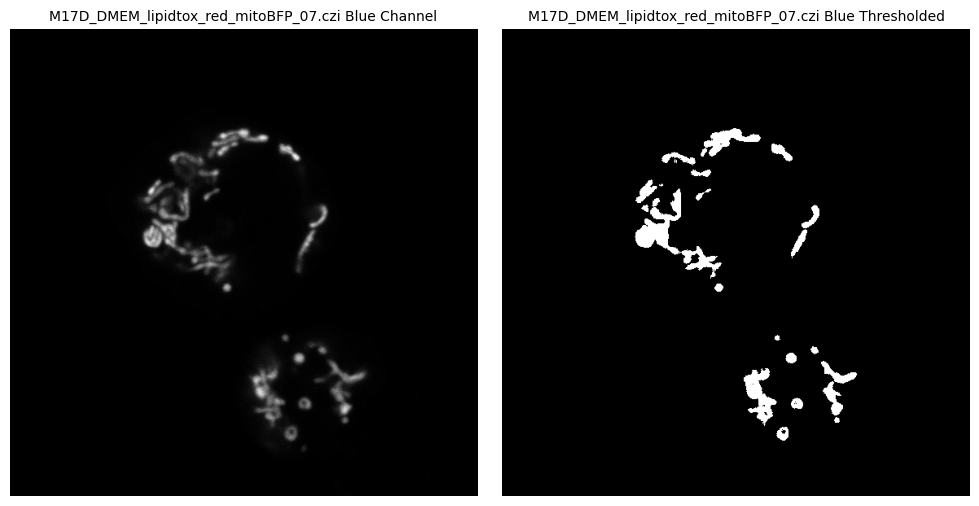

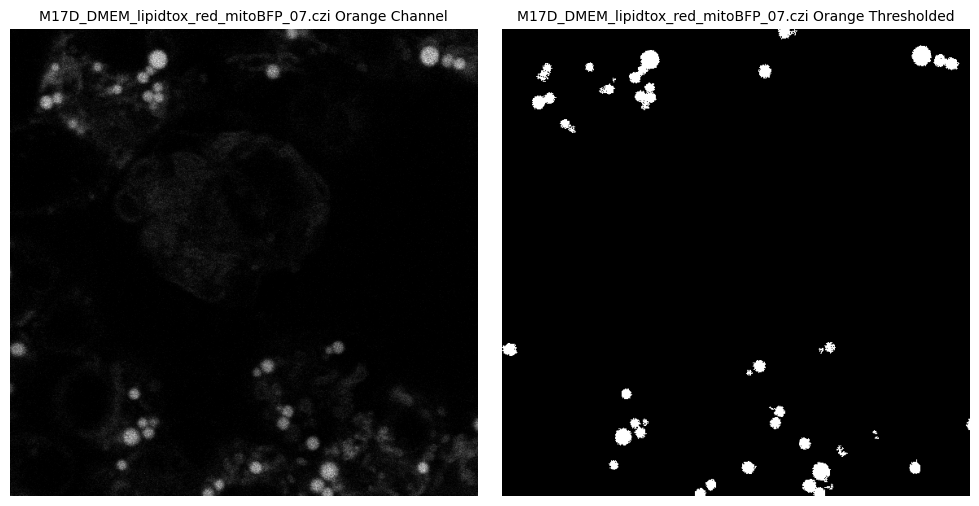

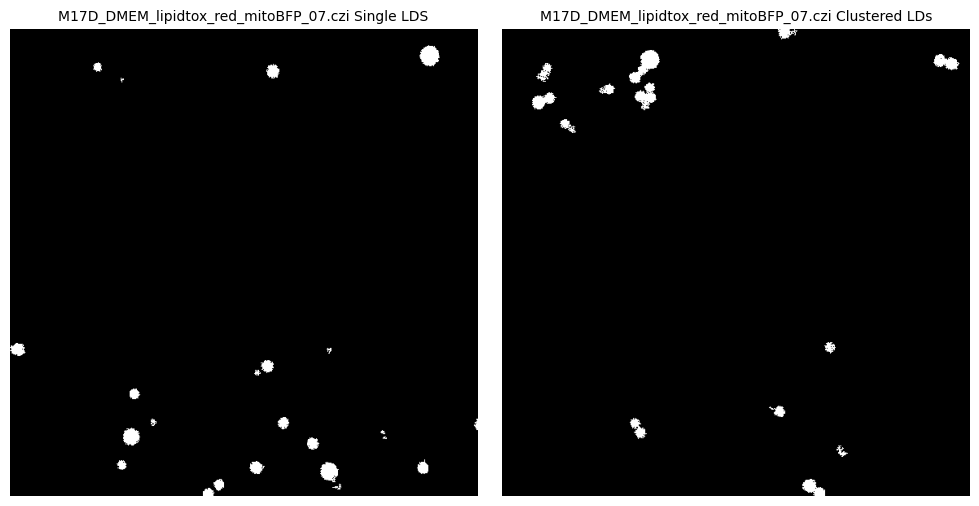

Starting analysis...


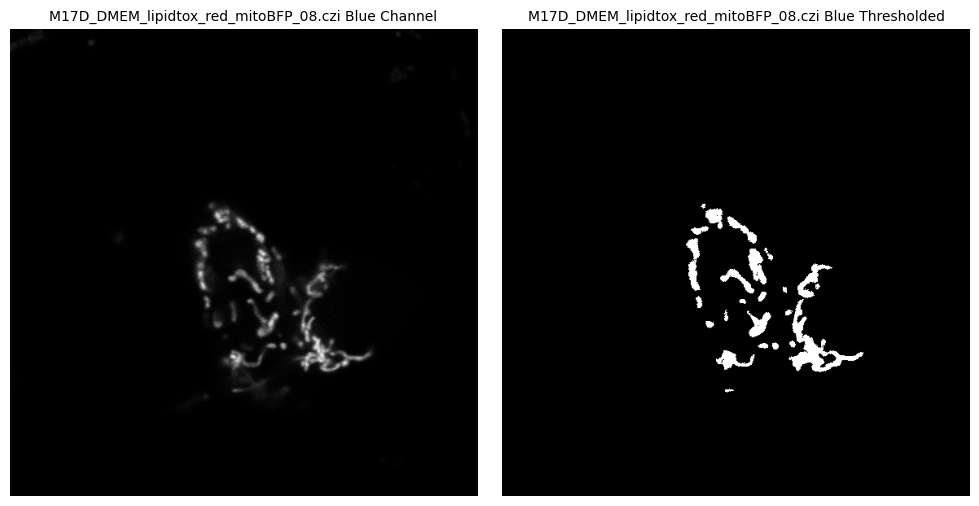

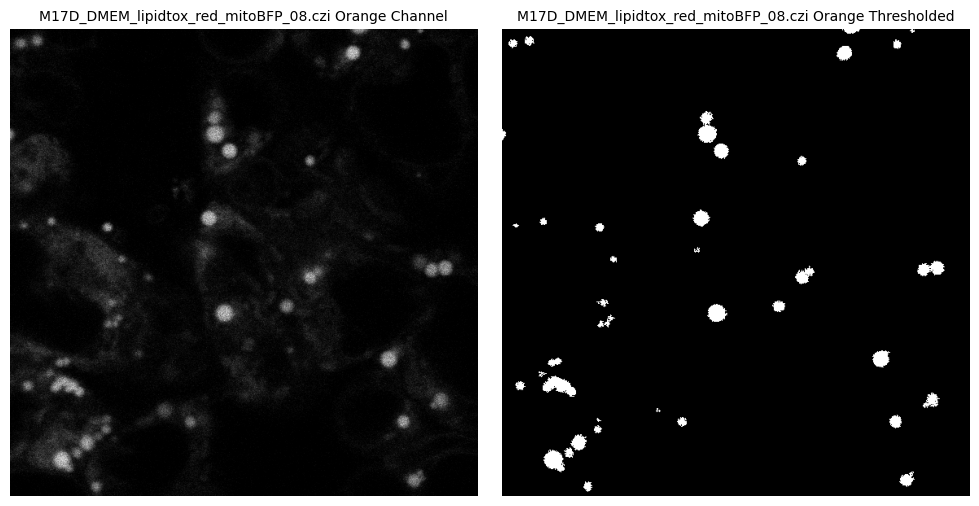

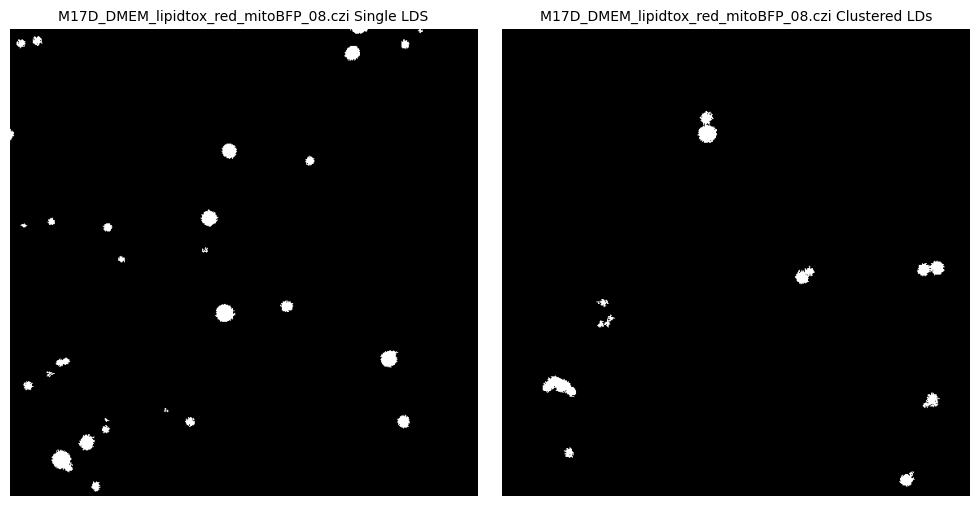

Starting analysis...


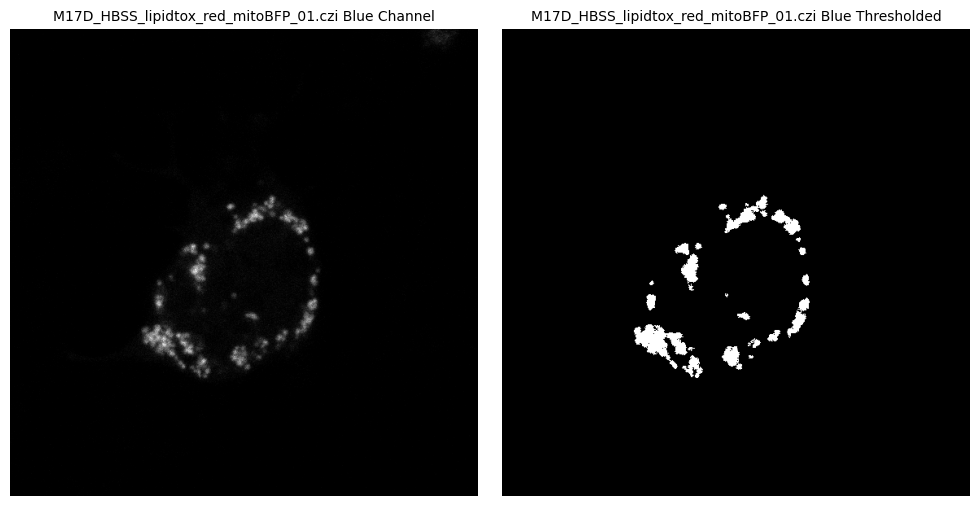

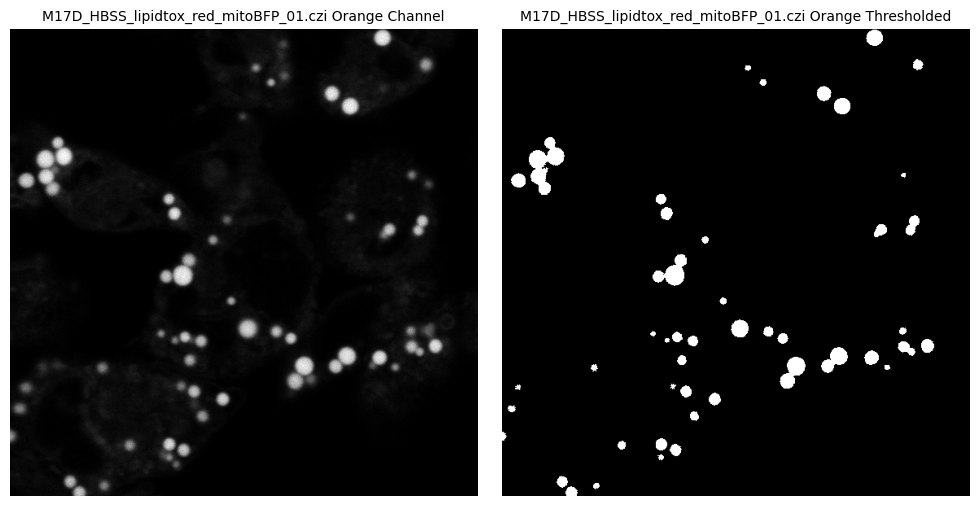

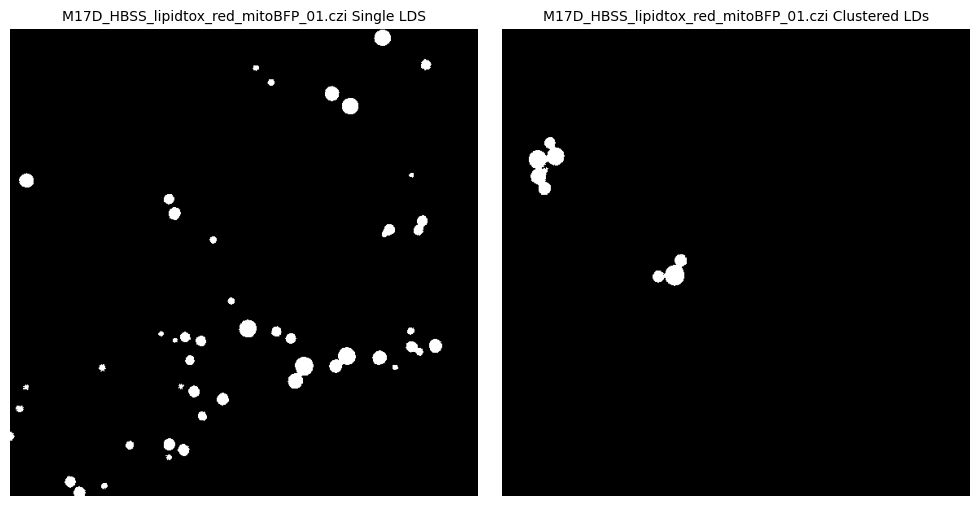

Starting analysis...


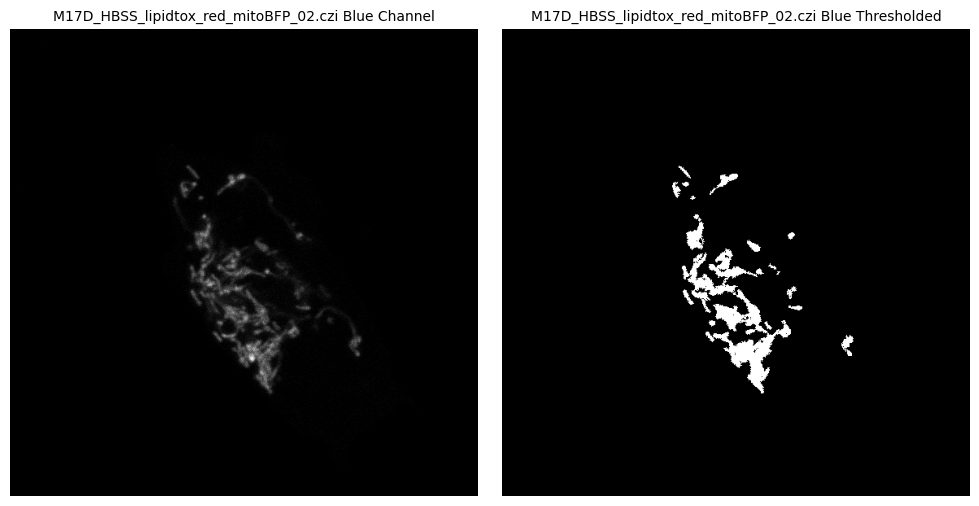

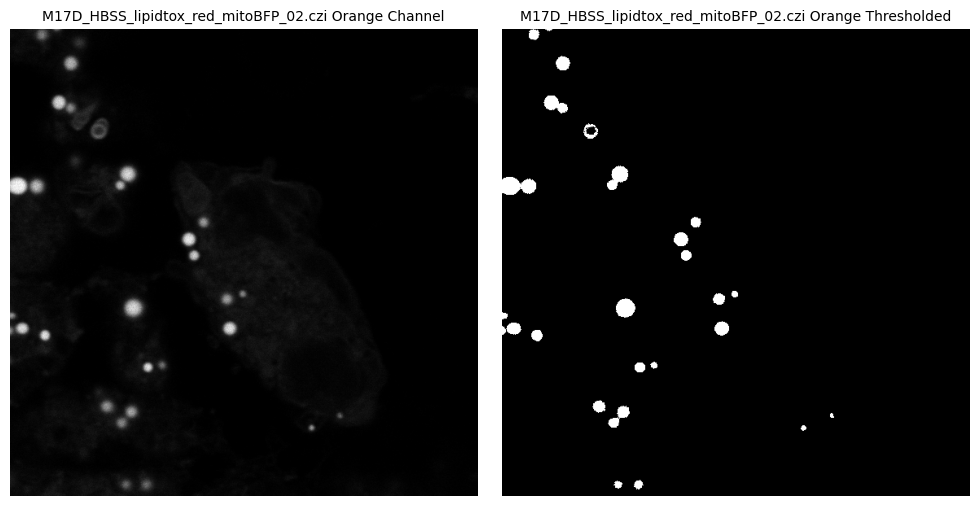

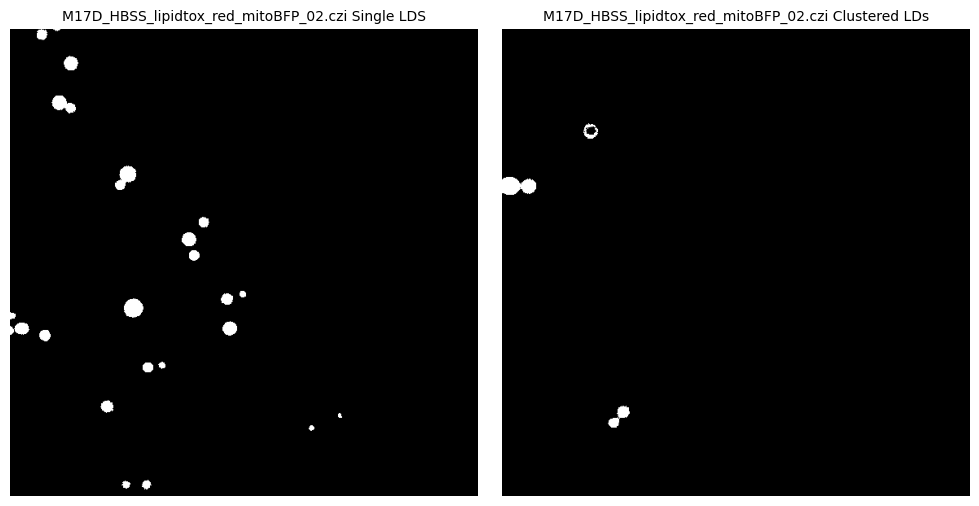

Starting analysis...


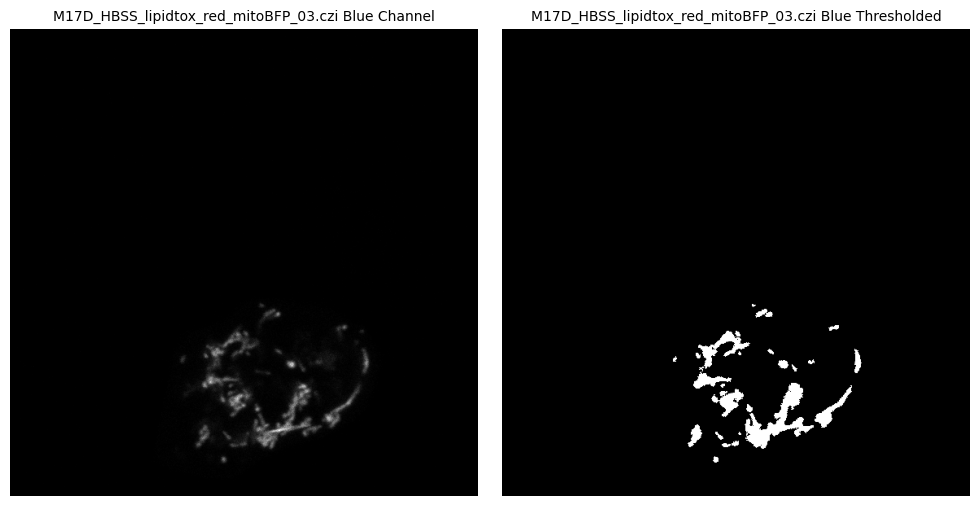

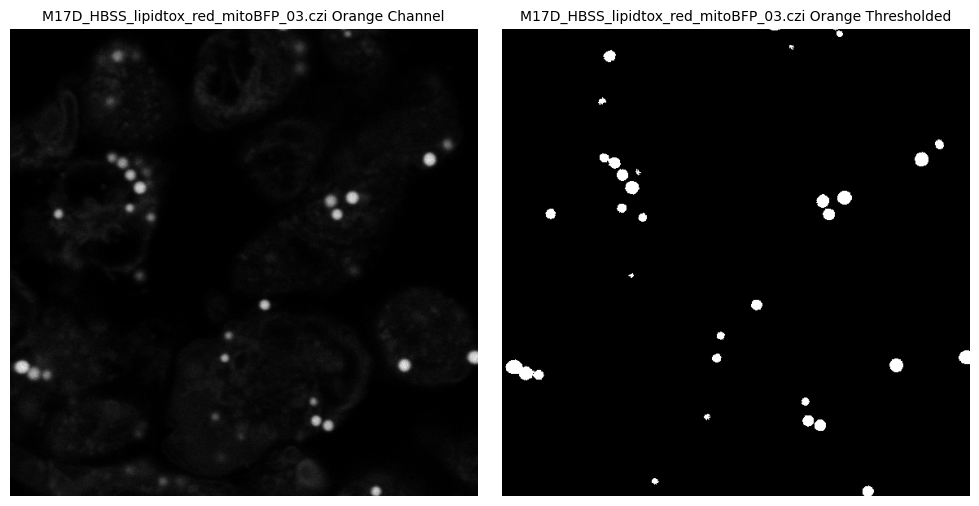

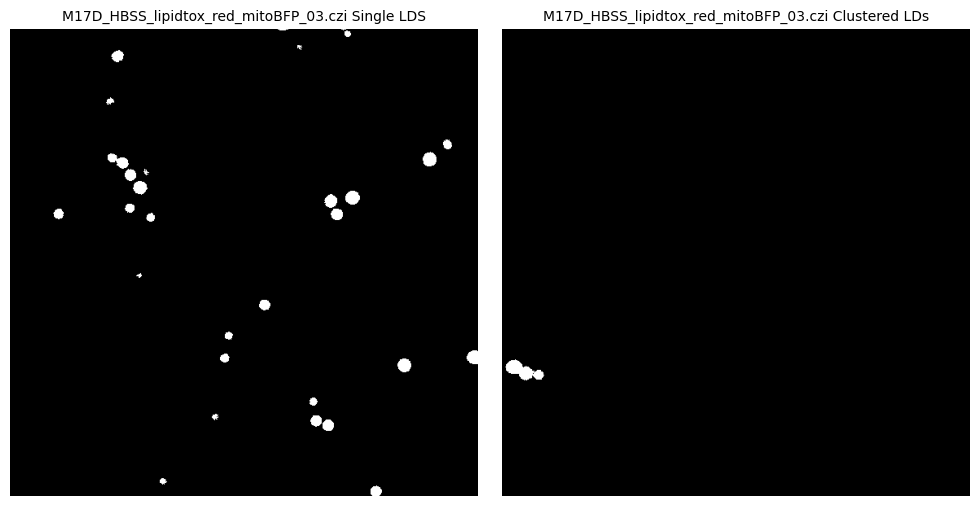

Starting analysis...


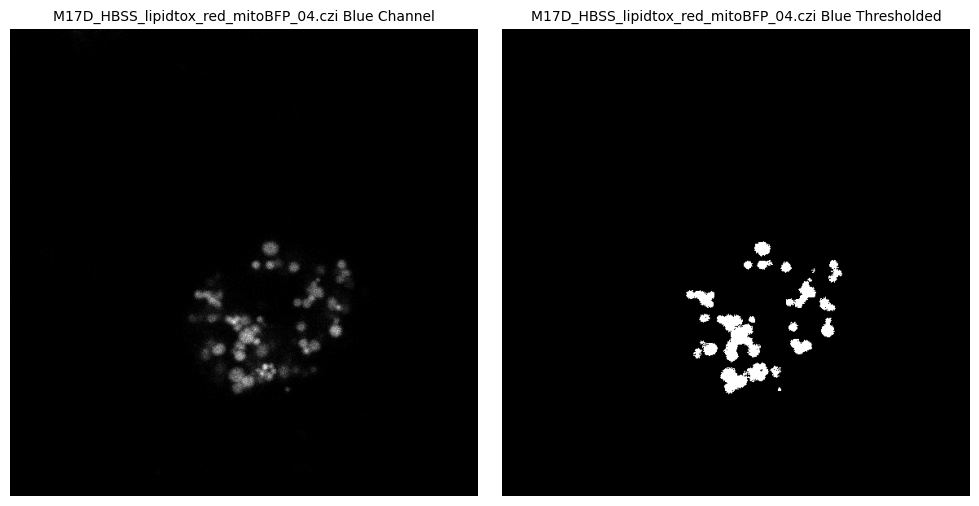

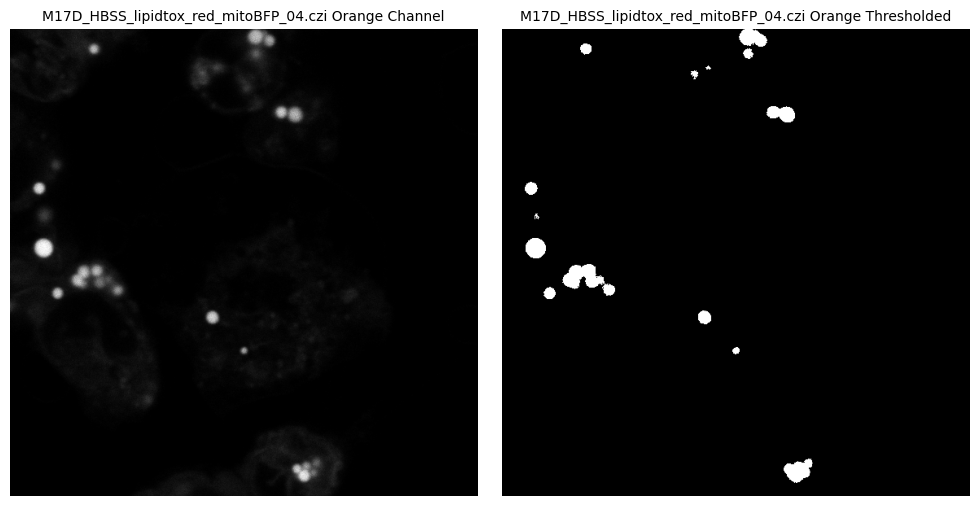

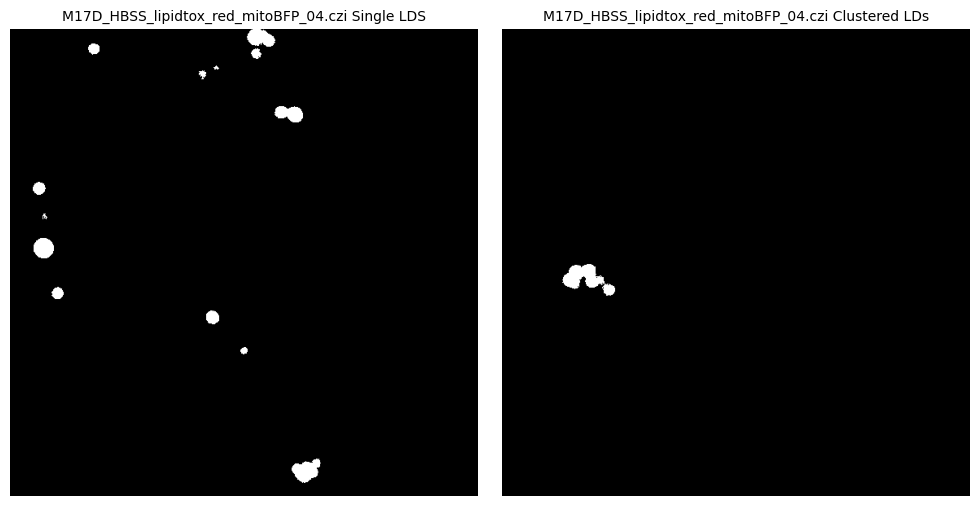

Starting analysis...


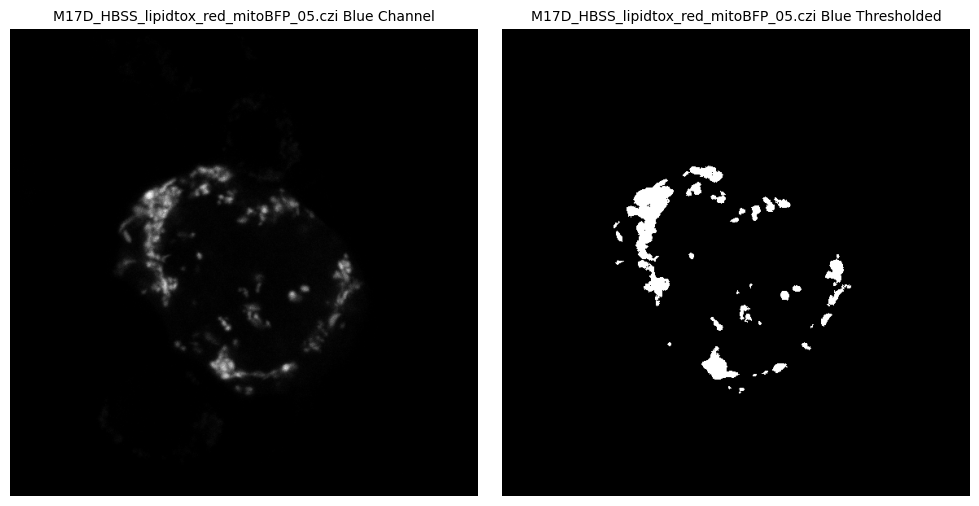

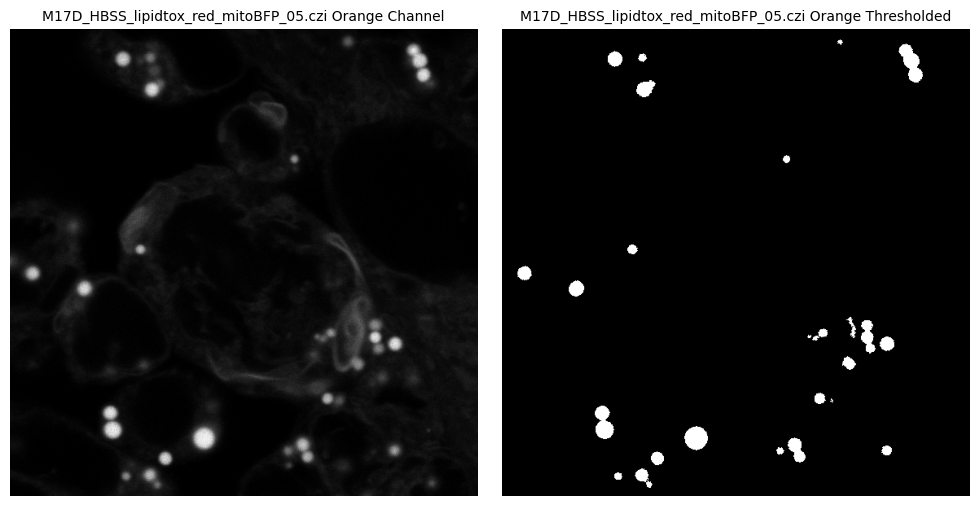

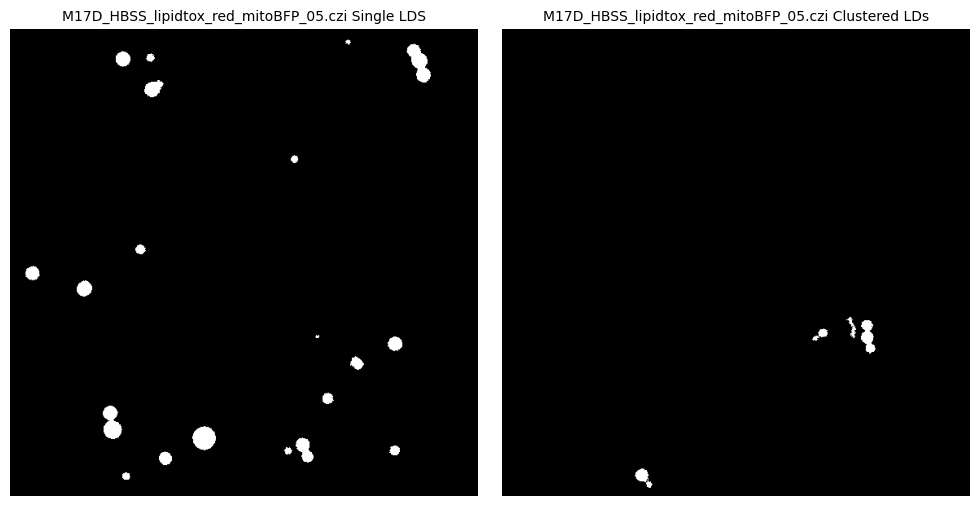

Starting analysis...


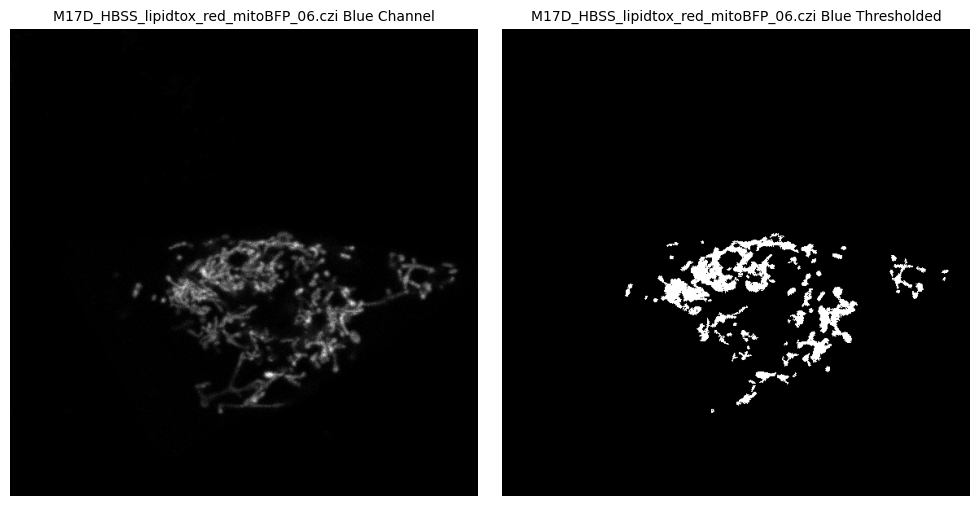

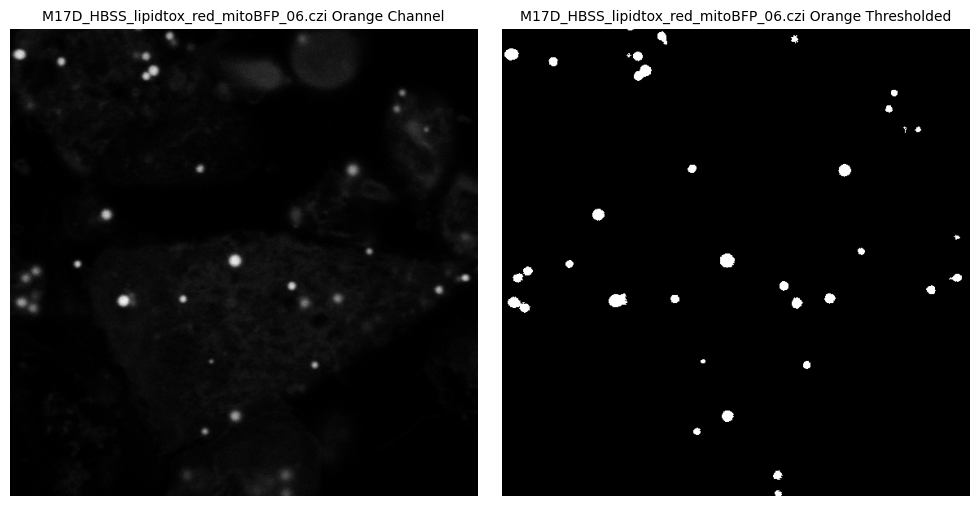

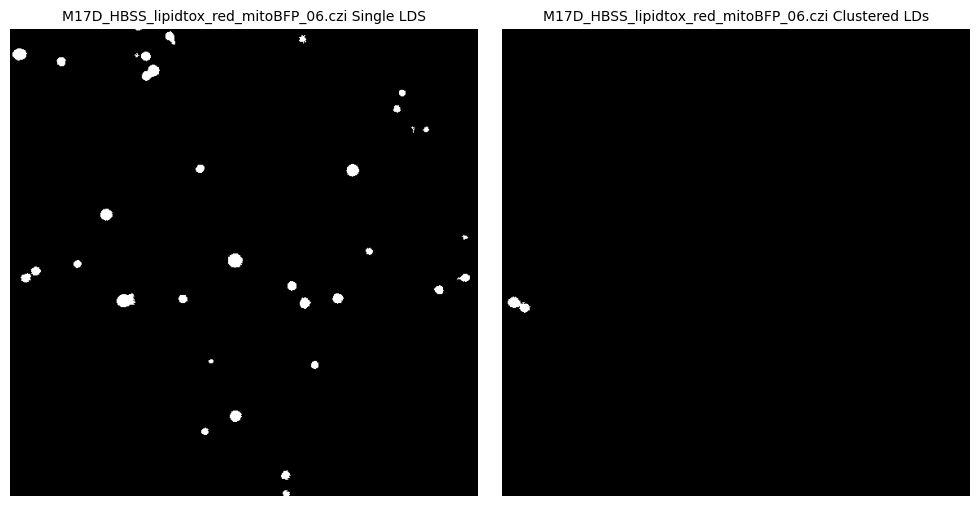

Starting analysis...


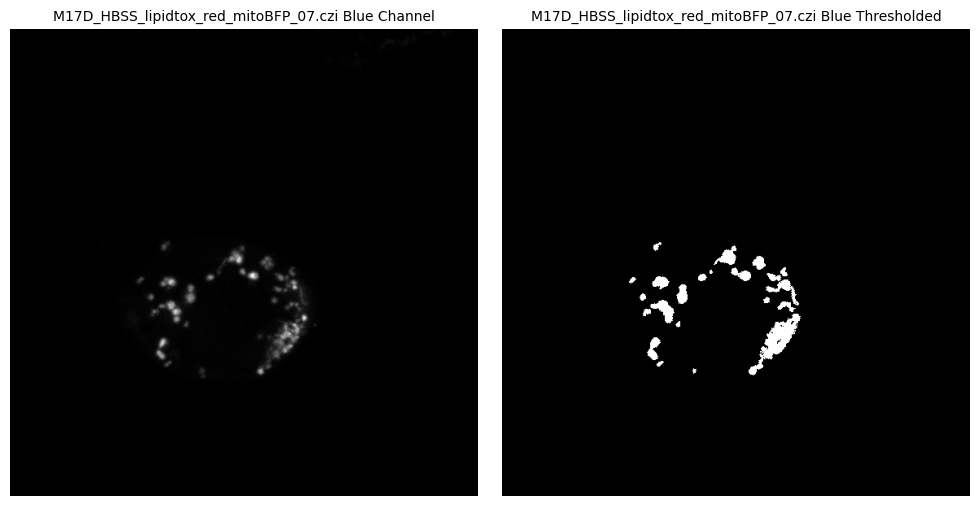

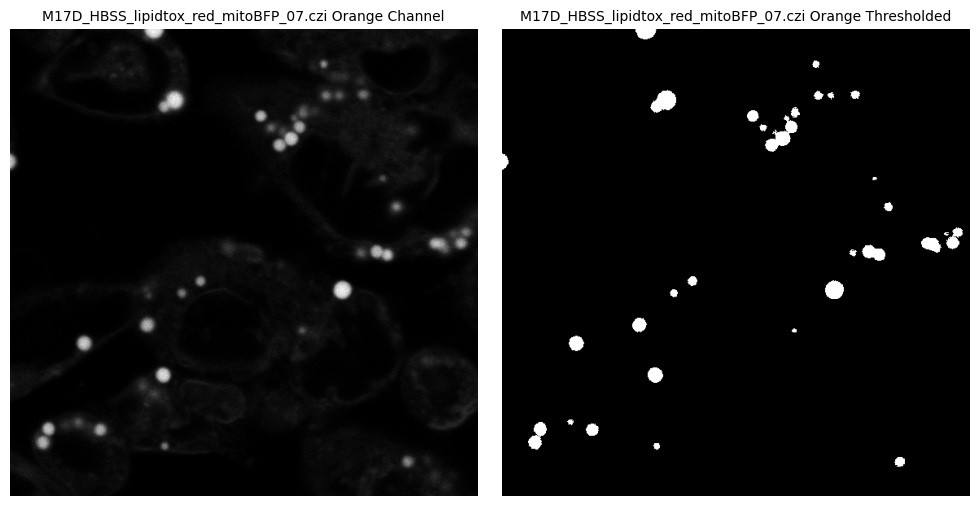

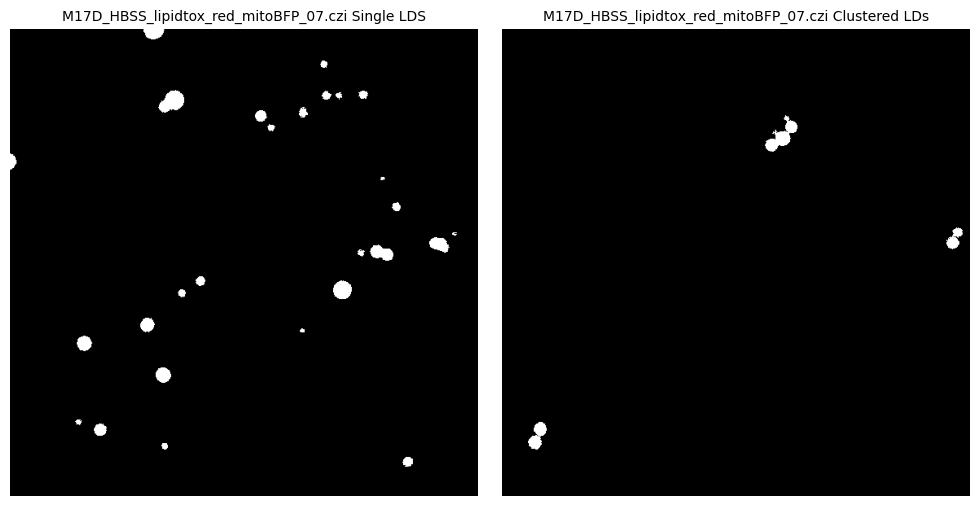

Starting analysis...


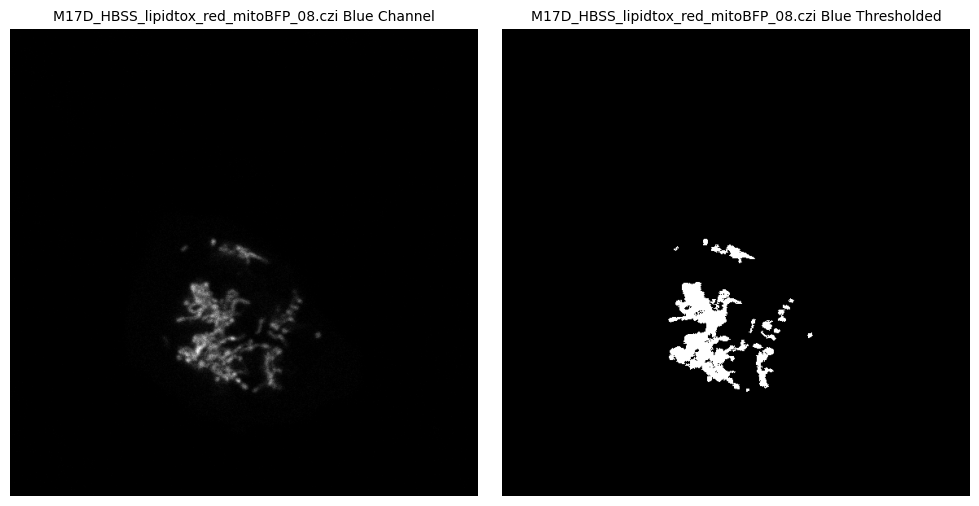

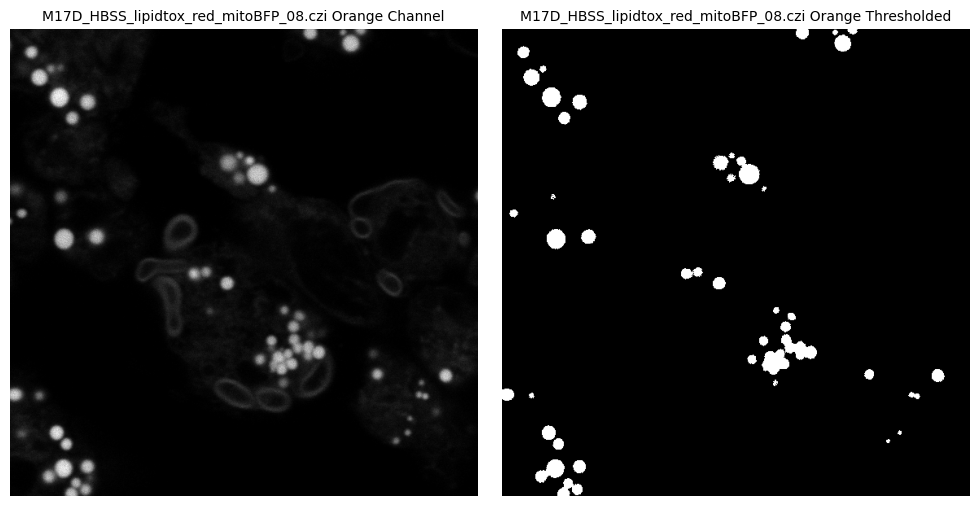

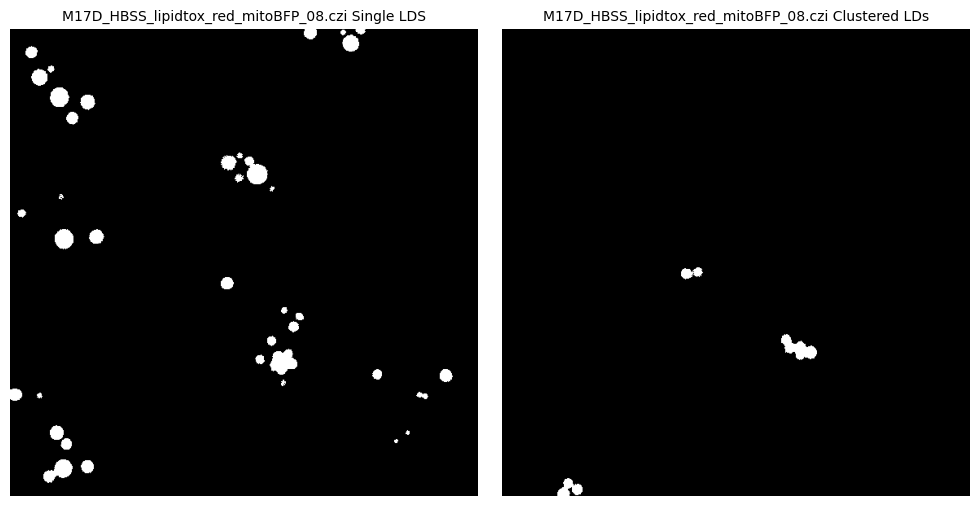

In [61]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()
    df_cell_summary_list = []
    df_lipid_distance_list = []


    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
    
        orange, blue = extract_channels(image_squeezed)

        df_cell_summary, df_lipid_distance = analysis(orange, blue, path)
        df_cell_summary_list.append(df_cell_summary)
        df_lipid_distance_list.append(df_lipid_distance)

    combined_cell_summary_df = pd.concat(df_cell_summary_list, ignore_index=True)
    combined_lipid_distance_df = pd.concat(df_lipid_distance_list, ignore_index=True)
    output_summary_path = os.path.join(output_dir, '092425_SUMMARY.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)
    combined_lipid_distance_df.to_excel(os.path.join(output_dir, '092425_LIPID_DISTANCE.xlsx'), index=False)

if __name__ == "__main__":
    image_folder = '092425_images'
    main(image_folder)